### Long term to-do:
Make the covariates and sentiment dataframes use same season (covariates call 2017-2018 "2018", while sentiment calls it "2017")

Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)
  
Get NFL dataset for comparison

Get Twitter data for comparison

In [1]:
import json
import string
import pandas as pd
import numpy as np
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
import sports_sentiment as ss

In [4]:
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [5]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [6]:
non_players_set = set('Atlanta Hawks Boston Celtics Brooklyn Nets Charlotte Bobcats' \
                  'Chicago Bulls Cleveland Cavaliers cavs Dallas Mavericks mavs Denver Nuggets ' \
                  'Detroit Pistons Golden State Warriors Houston Rockets Indiana'\
                  'Pacers Los Angeles LA Clippers LA Lakers LAL Memphis Grizzlies Miami Heat '\
                  'Milwaukee Bucks Minnesota Timberwolves  New Orleans Hornets New York Knicks NYK '\
                  'Oklahoma City Thunder Orlando Magic Philadelphia Sixers 76ers Phoenix'\
                  'Suns Portland Trail Blazers Sacramento Kings'\
                  'San Antonio Spurs Toronto Raptors Utah Jazz Washington Wizards wiz'\
                      'NBA asg'.lower().split())

### Instantiate sentiment analyzer

In [20]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously']
bad_words = ['foul', 'vicious', 'ridiculous', 'motherfucking', 'mediocre', 'soft']
great_words = ['goat', 'nasty', 'prime', 'mvp']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

## Load player demographic and performance data
#### Demographics
# I also have data from 2013 onwards; need to update it with race info

In [8]:
demo_df = pd.read_csv('data/covariates/nba_players2018.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()

Fix heights

In [9]:
demo_df['Ht'] = demo_df['Ht'].str.split('-')
height_dict = {'Jun':72, 'Jul':84, 'May':60}
height_dict.update({str(x):x for x in range(13)})
height_dict.update({'00':0})
demo_df['Ht'] = demo_df['Ht'].apply(lambda row: height_dict[row[0]] + height_dict[row[1]])

#### Player performance

In [11]:
performance2018_df = ss.get_year_performance_nba(2018)
performance2017_df = ss.get_year_performance_nba(2017)
performance2016_df = ss.get_year_performance_nba(2016)
performance_df = pd.concat([performance2016_df, performance2017_df, performance2018_df])

C:\Users\map22_nyfxjnv\Documents\GitHub\trailofpapers\sentiment_nba\sports_sentiment.py:60: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  team_player_df = (pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html')[0]
C:\Users\map22_nyfxjnv\Documents\GitHub\trailofpapers\sentiment_nba\sports_sentiment.py:44: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  return (advanced_df.merge(basic_df, on='Player')


In [12]:
performance_df.head()

,Rk,Player,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year
0,1,quincy acy,PF,25,59,876,14.7,0.629,0.229,0.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,NaN,1.8,0.7,2.5,0.137,NaN,0.2,0.0,0.2,0.5,SAC,2.0,3.6,0.556,0.3,0.8,0.388,1.7,2.8,0.606,0.600,0.8,1.2,0.735,1.1,2.1,3.2,0.5,0.5,0.4,0.5,1.7,5.2,2016
1,2,jordan adams,SG,21,2,15,17.3,0.427,0.167,0.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,NaN,0.0,0.0,0.0,0.015,NaN,-2.9,4.8,1.9,0.0,MEM,1.0,3.0,0.333,0.0,0.5,0.000,1.0,2.5,0.400,0.333,1.5,2.5,0.600,0.0,1.0,1.0,1.5,1.5,0.0,1.0,1.0,3.5,2016
2,3,steven adams,C,22,80,2014,15.5,0.621,0.000,0.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,NaN,4.2,2.3,6.5,0.155,NaN,0.8,1.3,2.1,2.1,OKC,3.3,5.3,0.613,0.0,0.0,NaN,3.3,5.3,0.613,0.613,1.4,2.5,0.582,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0,2016
3,4,arron afflalo,SG,30,71,2371,10.9,0.531,0.298,0.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,NaN,1.8,0.9,2.7,0.055,NaN,-0.6,-1.8,-2.4,-0.2,NYK,5.0,11.3,0.443,1.3,3.4,0.382,3.7,7.9,0.469,0.500,1.5,1.8,0.840,0.3,3.4,3.7,2.0,0.4,0.1,1.2,2.0,12.8,2016
4,5,alexis ajinca,C,27,59,861,13.8,0.514,0.003,0.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,NaN,0.2,0.9,1.0,0.058,NaN,-4.3,-0.2,-4.5,-0.5,NOP,2.5,5.3,0.476,0.0,0.0,0.000,2.5,5.3,0.478,0.476,0.9,1.1,0.839,1.3,3.3,4.6,0.5,0.3,0.6,0.9,2.3,6.0,2016


In [49]:
#performance_df.to_csv('data/nba_stats_2016-2018.tsv', sep='\t', index = False)
performance_df = pd.read_csv('data/nba_stats_2016-2018.tsv', sep='\t')

#### City and team info

In [51]:
#year=2016
#team2016_df = pd.concat(pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}.html')[:2]).assign(year = year)
# then hand edit the 3-letter team names
team_df = pd.concat([pd.read_csv('data/covariates/nba_teams2016.tsv', sep='\t'),
                     pd.read_csv('data/covariates/nba_teams2017.tsv', sep='\t'),
                     pd.read_csv('data/covariates/nba_teams2018.tsv', sep='\t')])

In [52]:
# city demographics
city_df = pd.read_csv('data/covariates/nba_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])

In [53]:
vote_df = pd.read_csv('data/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

#### Combine info

In [85]:
covariates_df = (demo_df.merge(performance_df, on = 'Player')
                      .merge(team_df, on=['Tm', 'year'])
                      .merge(city_df, on='Tm')
                      .merge(vote_df, on='Tm')
                      .drop(columns = ['experience']))
covariates_df['experience'] = covariates_df['year'] - covariates_df['From']
covariates_df.head(2)

,Player,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Race,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,alex abrines,2017,2018,G-F,78,190,1-Aug-93,NaN,W,1,SG,23,68,1055,10.1,0.560,0.724,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,NaN,1.2,0.9,2.1,0.096,NaN,-0.3,-2.2,-2.5,-0.1,OKC,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,47,1337075,74.1,10.2,0.1051,0
1,steven adams,2014,2018,C,84,255,20-Jul-93,University of Pittsburgh,W,3,C,23,80,2389,16.5,0.589,0.002,0.392,13.0,15.4,14.2,5.4,1.8,2.6,16.0,16.2,NaN,3.3,3.1,6.5,0.130,NaN,-0.7,1.2,0.6,1.5,OKC,4.7,8.2,0.571,0.0,0.0,0.000,4.7,8.2,0.572,0.571,2.0,3.2,0.611,3.5,4.2,7.7,1.1,1.1,1.0,1.8,2.4,11.3,2017,47,1337075,74.1,10.2,0.1051,3


#### Player names for entity recognition and fuzzy matching

In [23]:
UNIQUE_NAMES = set(demo_df.Player.unique())

In [24]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'lma', 'kd', 'lbj','klove', 'drose', 'kobe', 'mj', 'magic', 'bird', 'wilt', 'chamberlain'})
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Black', 'Ball', 'Brown', 'Buddy', 'Grant', 'House', 'Smart', 'Holiday', 'Love', 'Rose', 'Smart', 'Stone','Temple', 
                  'Wall', 'Will', 'White', 'Wear'}
NAMED_ENTITIES = NAMED_ENTITIES - {'a'} - {name.lower() for name in UPPER_ENTITIES}
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)
NAMED_ENTITIES = NAMED_ENTITIES.union(non_players_set)

## Load data
### Reddit
#### 2017-18 season

In [ ]:
%%time
_, oct_df = ss.create_sentiment_df('data/201710-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, nov_df = ss.create_sentiment_df('data/201711-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, dec_df = ss.create_sentiment_df('data/201712-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, jan_df = ss.create_sentiment_df('data/201801-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, feb_df = ss.create_sentiment_df('data/201802-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, mar_df = ss.create_sentiment_df('data/201803-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, apr_df = ss.create_sentiment_df('data/201804-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, may_df = ss.create_sentiment_df('data/201805-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)

In [144]:
nba2017_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2017_df.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


(1312264, 17)

In [145]:
nba2017_df.to_csv('data/combined_months_ner_sentiment_2017.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2016 season

In [ ]:
%%time
_, oct_df = ss.create_sentiment_df('data/201610-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, nov_df = ss.create_sentiment_df('data/201611-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, dec_df = ss.create_sentiment_df('data/201612-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, jan_df = ss.create_sentiment_df('data/201701-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, feb_df = ss.create_sentiment_df('data/201702-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, mar_df = ss.create_sentiment_df('data/201703-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, apr_df = ss.create_sentiment_df('data/201704-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, may_df = ss.create_sentiment_df('data/201705-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)

In [147]:
nba2016_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2016_df.shape

(888935, 16)

In [148]:
nba2016_df.to_csv('data/combined_months_ner_sentiment_2016.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2015 season

In [ ]:
%%time
_, oct_df = ss.create_sentiment_df('data/201510-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, nov_df = ss.create_sentiment_df('data/201511-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, dec_df = ss.create_sentiment_df('data/201512-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, jan_df = ss.create_sentiment_df('data/201601-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, feb_df = ss.create_sentiment_df('data/201602-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, mar_df = ss.create_sentiment_df('data/201603-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, apr_df = ss.create_sentiment_df('data/201604-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)
_, may_df = ss.create_sentiment_df('data/201605-comments_submissions.tsv.gz', sid.polarity_scores, UNIQUE_NAMES, ner_set=NAMED_ENTITIES)

In [27]:
nba2015_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2015_df.shape

(947382, 16)

In [28]:
nba2015_df.to_csv('data/combined_months_ner_sentiment_2015.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### Save / load

In [75]:
#nba2015_df = pd.read_csv('data/combined_months_ner_sentiment_2015.tsv',sep='\t', encoding = 'utf-8')
#nba2015_df['named_entities'] = nba2015_df['named_entities'].apply(literal_eval)
#nba2016_df = pd.read_csv('data/combined_months_ner_sentiment_2016.tsv',sep='\t', encoding = 'utf-8')
#nba2016_df['named_entities'] = nba2016_df['named_entities'].apply(literal_eval)
nba2017_df = pd.read_csv('data/combined_months_ner_sentiment_2017.tsv',sep='\t', encoding = 'utf-8').drop(columns='Unnamed: 0')
nba2017_df['named_entities'] = nba2017_df['named_entities'].apply(literal_eval)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [77]:
%%time
nba2017_df['fuzzy_name'] = nba2017_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
#nba2016_df['fuzzy_name'] = nba2016_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
#nba2015_df['fuzzy_name'] = nba2015_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 24.5 s


Remove players whose names have implicit sentiment

In [78]:
senti_players = ['jerian grant', 'jerami grant', 'marcus smart', 'justin holiday','jrue holiday', 'kevin love', 'derrick favors']
nba2017_df = nba2017_df[nba2017_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
#nba2016_df = nba2016_df[nba2016_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
#nba2015_df = nba2016_df[nba2015_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

In [76]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'draymond sessions', 'jalen jalen', 'brown markelle', 'kyrie korver', 'kyrie singler',
                    'wade drummond', 'kyrie anderson', 'kyle irving', 'kyle ingles', 'kyle turner', 'kyle turner', 'jabari maker',
                    'walton walton', 'nene kanter', 'courtney love', 'george will', 'charles charles', 'jason aaron', 'lebron jae',
                    'sterling lebron', 'bobby lebron', 'damien', 'cleveland', 'cleveland cleveland', 'ben ben', 'martin', "o'bryant",
                                       'sam sam', 'shaquille shaquille', 'blue', 'jamal curry', 'david westbrook', 'griffin baker', 'chris pau',
                                       'jimmy tyler', 'jamal curry', 'jamal curry' 'london','jackson tatum']}
name_map.update({'giannis':'giannis antetokounmpo',
                'kd':'kevin durant',
                 'lbj':'lebron james',
                 'lma':'lamarcus aldridge'})

In [218]:
match_df[['fuzzy_name', 'str_entities']].query('fuzzy_name != str_entities')['str_entities'].value_counts().head(500).tail(50)

dakari               53
kentavious           53
cameron              52
dellavedova          52
butler butler        52
galloway             51
lorenzo              51
terrance             51
bird bird            50
derozan derozan      50
roberson roberson    50
aaron baynes         50
marquese             50
randle ingram        49
qi                   49
mbah                 49
rubio rubio          49
terrence             49
oladipo oladipo      48
o'neale              48
treveon              48
harden james         48
nogueira             45
blue blue            45
cory                 45
leuer                44
ellenson             44
korkmaz              44
motley               43
house house          43
calderon rose        43
ekpe                 43
jackson tatum        43
furkan               43
marshon              42
aldrich              42
beal beal            42
holland              41
ferrell              41
felder               41
darius miles         40
whitehead       

In [79]:
match_df = nba2017_df.query('fuzzy_name != "unclear"')
match_df.shape

(758386, 16)

#### First calculate the average sentiment for each player from each user

In [80]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df.head(2)

,fuzzy_name,user,compound_mean,compound_std,comment_count
0,aaron brooks,666mafioso,0.6705,NaN,1
1,aaron brooks,76Answers,0.4927,NaN,1


#### Then calculate the average sentiment to players across all users

In [81]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby('fuzzy_name')
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'compound_mean_mean', 'compound_mean_std', 'user_count']

### Exploration of sentiment alone
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

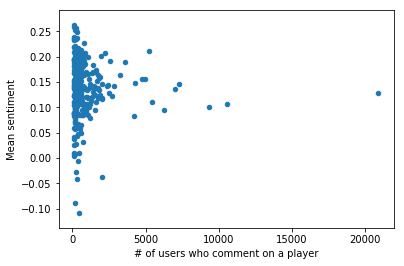

In [190]:
player_sentiment_df.query('user_count> 100').plot('user_count', 'compound_mean_mean', kind='scatter')
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [25]:
player_sentiment_df.sort_values('user_count', ascending=False).head()

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
316,lebron james,0.128983,0.344258,20887
292,kevin durant,0.105746,0.379737,10575
212,james harden,0.101097,0.374204,9357
455,stephen curry,0.144980,0.371942,7281
308,kyrie irving,0.135729,0.378417,6983


#### Players with lowest sentiment

In [26]:
player_sentiment_df.query('user_count > 100').sort_values('compound_mean_mean').head()

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
456,sterling brown,-0.108161,0.452348,415
33,arron afflalo,-0.088347,0.462434,149
438,salah mejri,-0.041684,0.467865,309
527,zaza pachulia,-0.037957,0.428695,2041
232,jeff teague,-0.028511,0.465854,215


In [27]:
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "sterling brown"')

#### Players with highest sentiment

In [28]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
258,jonathan isaac,0.234396,0.393705,239
502,tyus jones,0.236590,0.390925,316
36,bam adebayo,0.248597,0.401567,313
75,cole aldrich,0.251906,0.384975,211
325,luke kennard,0.257164,0.391741,220


#### Players with highest std of sentiment

In [31]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
275,julyan stone,0.087713,0.480701,315
116,dennis schroder,0.057185,0.473741,201
438,salah mejri,-0.041684,0.467865,309
232,jeff teague,-0.028511,0.465854,215
205,jalen jones,0.105447,0.461664,299


#### Join player sentiment to performance and demographics
Include only players with at least 100 comments to avoid fitting noise

In [198]:
join_df = (player_sentiment_df.query('user_count > 50')
                         .merge(covariates_df.query('year == 2018'), left_on = 'fuzzy_name', right_on = 'Player')
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24']))

### Explore demographics relationship with sentiment

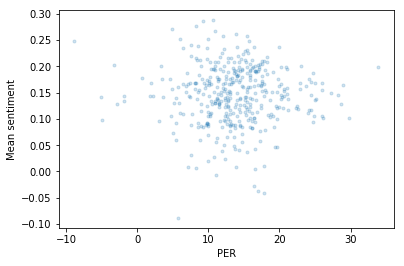

In [160]:
plt.plot(join_df['PER'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.2);
plt.xlabel('PER')
plt.ylabel('Mean sentiment');

In [87]:
join_df.groupby('Race').mean()

,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
Race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.102126,0.461361,337.000000,2011.000000,2018.0,75.000000,200.000000,277.666667,28.000000,38.333333,985.333333,16.300000,0.565667,0.289000,0.445667,1.166667,8.700000,4.966667,27.066667,1.233333,0.966667,15.733333,26.700000,0.866667,1.033333,1.866667,0.095000,-0.500000,-3.666667,-4.133333,0.433333,4.566667,10.800000,0.422333,1.200000,3.066667,0.402667,3.400000,7.733333,0.442000,0.477333,4.433333,4.866667,0.877000,0.266667,2.033333,2.333333,4.033333,0.633333,0.300000,2.433333,2.433333,14.733333,2017.000000,32.000000,1.414801e+07,61.933333,18.800000,0.511767,6.000000
B,0.137127,0.415443,1153.379545,2011.265909,2018.0,78.361364,216.152273,247.022727,26.411364,64.109091,1736.668182,15.252045,0.540319,0.311535,0.271872,4.324545,15.201591,9.785682,16.416818,1.685455,1.646818,12.780410,20.719091,2.277500,1.850455,4.126818,0.099420,-0.002273,-0.073636,-0.075000,1.284773,4.513636,9.920000,0.451162,1.077045,3.039091,0.317561,3.435455,6.881364,0.491482,0.505239,2.188636,2.836818,0.757288,0.986136,3.588864,4.568182,2.827500,0.897045,0.521364,1.606818,1.994773,12.288182,2017.090909,42.977273,5.194994e+06,67.305000,14.949545,0.370517,5.825000
M,0.152484,0.416392,1859.033333,2011.933333,2018.0,78.333333,212.166667,287.366667,26.100000,63.733333,1783.033333,17.006667,0.547600,0.262833,0.253867,5.040000,14.803333,10.003333,18.916667,1.786667,1.226667,12.673333,22.043333,2.876667,1.830000,4.676667,0.118200,1.183333,-0.006667,1.160000,1.586667,5.260000,11.173333,0.468800,1.376667,3.550000,0.309276,3.880000,7.616667,0.502833,0.518233,2.106667,2.776667,0.732400,1.093333,3.586667,4.690000,3.303333,0.940000,0.380000,1.683333,2.010000,13.983333,2017.066667,45.733333,8.905304e+06,59.103333,9.493333,0.475180,5.133333
R,-0.041684,0.467865,309.000000,2016.000000,2018.0,85.000000,245.000000,310.333333,30.000000,56.000000,677.000000,16.466667,0.643333,0.019000,0.505667,11.933333,25.466667,18.500000,4.500000,1.433333,7.300000,19.200000,12.466667,1.066667,1.233333,2.333333,0.163333,-2.800000,4.266667,1.466667,0.566667,1.333333,2.133333,0.637333,0.000000,0.000000,0.111000,1.333333,2.100000,0.647333,0.638667,0.633333,1.100000,0.584333,1.300000,2.633333,3.933333,0.366667,0.333333,1.000000,0.600000,1.900000,3.366667,2017.000000,33.000000,6.957123e+06,69.700000,15.300000,0.262400,1.000000
W,0.145978,0.409916,795.938931,2011.580153,2018.0,81.351145,232.908397,229.557252,27.503817,63.694656,1497.641221,14.938931,0.563359,0.293229,0.282321,6.073282,18.096947,12.085496,12.161069,1.368702,1.944275,13.874809,18.596183,1.988550,1.711450,3.700763,0.111969,-0.470992,0.145802,-0.322137,0.935878,3.493893,7.415267,0.476000,0.854962,2.275573,0.323106,2.637405,5.141985,0.511977,0.530885,1.550382,2.015267,0.756984,1.154962,3.587786,4.741985,1.887023,0.621374,0.522901,1.263359,1.974046,9.392366,2017.106870,42.419847,5.379492e+06,68.565649,14.729008,0.377263,5.526718


#### Age / experience

Text(0,0.5,'Mean sentiment')

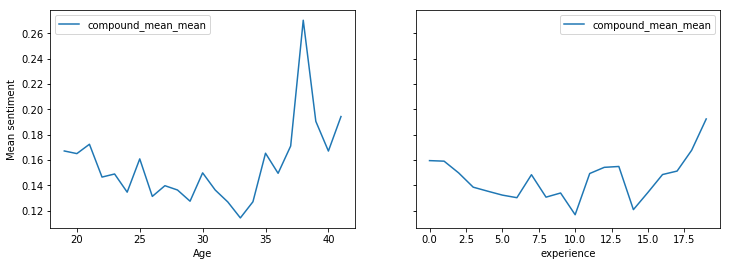

In [199]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax1);
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax2);
ax1.set_ylabel('Mean sentiment')

In [133]:
import seaborn as sns

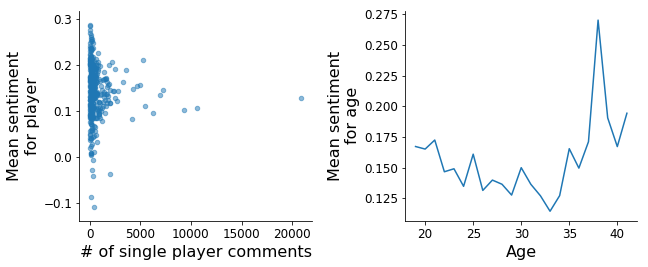

In [238]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = [10, 4])
fs = 16
player_sentiment_df.query('user_count> 50').plot('user_count', 'compound_mean_mean', kind='scatter', alpha = 0.5, ax = ax1)
#plt.plot([100, 100], [-0.1, 0.3])
plt.subplots_adjust(wspace=0.4)
ax1.tick_params(labelsize = fs-4)
ax1.set_xlabel('# of single player comments', fontsize = fs)
ax1.set_ylabel('Mean sentiment\nfor player', fontsize = fs)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax2);
ax2.tick_params(labelsize = fs-4)
ax2.set_xlabel('Age', fontsize = fs)
ax2.set_ylabel('Mean sentiment\nfor age', fontsize = fs)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend_.remove()
plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('comment count and age.png')

#### Height

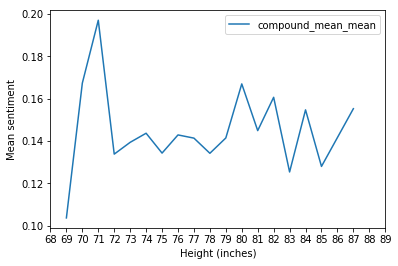

In [201]:
join_df.groupby('Ht').mean().reset_index().plot('Ht', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [164]:
join_df.groupby('Pos_y').mean().reset_index()

,Pos_y,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,experience,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,year,Wins,total_population,metro_percent_white,metro_percent_black
0,C,0.147896,0.414297,603.658824,2012.047059,2018.0,83.082353,249.470588,5.952941,278.941176,27.141176,56.658824,1174.223529,16.784706,0.574812,0.108812,0.396588,9.622353,22.556471,16.104706,10.060000,1.458824,3.542353,14.697647,18.258824,1.981176,1.652941,3.629412,0.131706,-1.221176,1.583529,0.354118,1.040000,3.220000,6.092941,0.527024,0.260000,0.777647,0.219791,2.954118,5.317647,0.550882,0.543224,1.454118,2.060000,0.697771,1.637647,4.000000,5.638824,1.316471,0.508235,0.771765,1.145882,2.014118,8.154118,2018.0,43.152941,6.128057e+06,66.992941,14.149412
1,PF,0.147005,0.418973,895.028986,2012.768116,2018.0,81.202899,234.420290,5.231884,258.768116,26.304348,60.623188,1440.942029,14.153623,0.546638,0.368739,0.228565,5.743478,18.444928,12.089855,10.121739,1.275362,1.894203,11.663768,19.284058,1.765217,1.544928,3.311594,0.092464,-0.839130,-0.250725,-1.094203,0.843478,3.789855,8.142029,0.454348,1.010145,2.797101,0.333773,2.781159,5.356522,0.509362,0.518884,1.536232,2.010145,0.743333,1.042029,3.757971,4.795652,1.611594,0.597101,0.537681,1.172464,1.830435,10.124638,2018.0,42.246377,5.015742e+06,68.991304,14.565217
2,PG,0.140453,0.420937,743.511364,2013.250000,2018.0,74.625000,188.931818,4.750000,288.534091,26.318182,50.784091,1237.590909,13.697727,0.523511,0.337977,0.243068,2.329545,11.232955,6.771591,24.014773,1.786364,0.848864,14.867045,21.196591,1.329545,1.178409,2.507955,0.071455,-0.613636,-1.167045,-1.782955,0.704545,3.605682,8.336364,0.425148,1.006818,2.832955,0.341628,2.595455,5.507955,0.459345,0.485523,1.692045,2.093182,0.788128,0.470455,2.252273,2.730682,3.702273,0.826136,0.227273,1.584091,1.677273,9.895455,2018.0,41.659091,5.509113e+06,67.440909,14.650000
3,PG-SG,0.111650,0.421378,63.000000,2014.000000,2018.0,72.000000,201.000000,4.000000,84.000000,26.000000,20.000000,422.000000,13.500000,0.539000,0.482000,0.372000,1.500000,10.000000,5.700000,26.700000,1.800000,0.200000,15.400000,18.900000,0.500000,0.100000,0.600000,0.072000,0.100000,-2.500000,-2.400000,0.000000,2.600000,6.900000,0.380000,1.100000,3.300000,0.333000,1.500000,3.600000,0.423000,0.460000,2.300000,2.600000,0.902000,0.300000,2.000000,2.300000,3.800000,0.800000,0.100000,1.500000,1.800000,8.600000,2018.0,21.000000,4.486153e+06,78.700000,5.200000
4,SF,0.151903,0.417694,450.461538,2013.076923,2018.0,79.615385,219.830769,4.923077,258.138462,26.646154,52.646154,1330.584615,10.918462,0.510077,0.420385,0.204862,3.153846,13.915385,8.536923,9.489231,1.720000,1.318462,11.747692,17.132308,1.015385,1.293846,2.315385,0.056723,-1.930769,-0.241538,-2.164615,0.518462,3.129231,7.143077,0.415862,1.012308,2.869231,0.327625,2.118462,4.276923,0.482281,0.483015,1.250769,1.615385,0.740550,0.607692,2.676923,3.280000,1.513846,0.740000,0.341538,1.007692,1.683077,8.520000,2018.0,41.015385,5.312466e+06,67.987692,14.270769
5,SF-SG,0.088146,0.424665,421.500000,2011.000000,2018.0,79.500000,204.500000,7.000000,210.500000,28.000000,57.500000,813.000000,13.300000,0.522000,0.246000,0.275500,5.050000,12.400000,8.750000,6.600000,2.150000,0.800000,7.450000,18.650000,0.600000,0.900000,1.500000,0.086000,-1.700000,-1.550000,-3.250000,0.000000,2.000000,4.400000,0.448000,0.300000,1.050000,0.270500,1.650000,3.300000,0.508500,0.481500,0.900000,1.250000,0.751000,0.550000,1.350000,1.950000,0.600000,0.650000,0.150000,0.400000,1.300000,5.150000,2018.0,44.500000,8.338901e+06,67.650000,7.250000
6,SG,0.142415,0.418168,689.302326,2013.081395,2018.0,77.069767,203.848837,4.918605,245.220930,26.593023,57.000000,1376.965116,12.415116,0.536767,0.467000,0.202035,2.123256,11.003488,6.556977,13.900000,1.605814,0.988372,12.013953,19.348837,1.300000,1.116279,2.416279,0.068919,-0.446512,-1.097674,

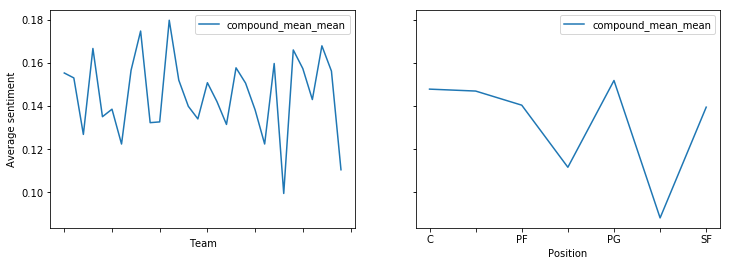

In [202]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Tm').mean().reset_index().plot('Tm', 'compound_mean_mean', ax = ax1);
ax1.set_xlabel('Team')
ax1.set_ylabel('Average sentiment')
join_df.groupby('Pos_y').mean().reset_index().plot('Pos_y', 'compound_mean_mean', ax = ax2);
ax2.set_xlabel('Position')
ax2.set_xticklabels(['', 'C','', 'PF','', 'PG','', 'SF','', 'SG']);

In [203]:
join_df.groupby('Tm').mean().sort_values('compound_mean_mean').head(2)

,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
Tm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PHO,0.099491,0.432994,307.133333,2014.866667,2018.0,78.2,209.866667,202.000000,24.600000,51.333333,1203.733333,12.706667,0.527733,0.349000,0.294933,4.040000,14.833333,9.353333,15.400000,1.680000,1.473333,13.740000,19.413333,0.546667,0.593333,1.140000,0.0424,-1.366667,-0.826667,-2.200000,-0.033333,3.500000,8.180000,0.432933,0.853333,2.640000,0.302286,2.640000,5.540000,0.477000,0.489467,1.760000,2.313333,0.751400,0.893333,3.033333,3.926667,2.166667,0.733333,0.413333,1.400000,2.020000,9.613333,2018.0,21.0,4486153.0,78.7,5.2,0.0345,3.133333
WAS,0.110487,0.415074,400.692308,2011.769231,2018.0,79.0,215.538462,343.153846,27.923077,66.076923,1532.384615,13.892308,0.546077,0.282385,0.275385,4.715385,14.615385,9.669231,16.838462,1.584615,1.623077,14.353846,19.353846,1.776923,1.538462,3.307692,0.0900,-0.676923,-0.284615,-0.969231,0.800000,3.623077,7.923077,0.456462,0.876923,2.392308,0.320417,2.746154,5.530769,0.495538,0.506077,1.630769,2.107692,0.777615,0.853846,2.923077,3.792308,2.623077,0.746154,0.392308,1.384615,1.946154,9.753846,2018.0,43.0,6011752.0,55.1,25.4,0.3622,6.230769


#### Create modeling dataframe

In [159]:
join_df['youth'] = (join_df['Age'].mean() - join_df['Age']).clip(0)
join_df['oldness'] = (join_df['Age'] - join_df['Age'].mean()).clip(0)

In [160]:
join_df = join_df.query('Race != "A" and Race != "R"')

In [161]:
join_df['ThreePP'] =join_df['ThreePP'].fillna(join_df['ThreePP'].mean())
join_df['white_black_diff'] = join_df['metro_percent_white'] - join_df['metro_percent_black']

In [162]:
join_df['height_dummies'] = pd.cut(join_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])

In [163]:
join_df.to_csv('2018_model_data.tsv', sep='\t', index=False)

In [179]:
fit_df = join_df.query('user_count > 200 and year == 2018')#.replace({'M':'B'})

In [157]:
fit_df.head(2)

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count,Player,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Race,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
1,aaron gordon,0.191616,0.432282,241,aaron gordon,2015,2018,F,81,220,16-Sep-95,University of Arizona,B,179,PF,22,58,1909,16.5,0.530,0.395,0.260,5.0,21.5,13.2,11.7,1.5,1.9,10.0,24.7,0.9,2.0,2.9,0.072,0.0,0.0,0.0,1.0,ORL,6.5,14.9,0.434,2.0,5.9,0.336,4.5,9.0,0.497,0.500,2.7,3.9,0.698,1.5,6.4,7.9,2.3,1.0,0.8,1.8,1.9,17.6,2018,25,2328508,71.2,16.3,0.2464,3
6,al horford,0.172538,0.401586,1634,al horford,2008,2018,C-F,82,245,3-Jun-86,University of Florida,B,227,C,31,72,2277,17.6,0.575,0.300,0.159,5.0,20.2,12.7,23.6,0.9,2.9,14.1,18.4,4.0,3.8,7.8,0.165,1.1,2.9,4.0,3.5,BOS,5.1,10.5,0.489,1.3,3.1,0.429,3.8,7.3,0.514,0.553,1.3,1.7,0.783,1.4,5.9,7.4,4.7,0.6,1.1,1.8,1.9,12.9,2018,55,4728844,77.3,8.0,0.3815,10


## Regression models
### Working models
First, a regression model for sentiment with features for performance, age, team wins, race, and height.

In [54]:
print([col for col in fit_df.columns])

['fuzzy_name', 'compound_mean_mean', 'compound_mean_std', 'user_count', 'Player', 'From', 'To', 'Pos_x', 'Ht', 'Wt', 'Birth Date', 'Colleges', 'experience', 'Race', 'Rk', 'Pos_y', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRBP', 'ASTP', 'STLP', 'BLKP', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Tm', 'FG', 'FGA', 'FG%', '3P', '3PA', 'ThreePP', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PPG', 'year', 'Wins', 'total_population', 'metro_percent_white', 'metro_percent_black', 'clinton_vote_lead', 'youth', 'oldness', 'height_dummies']


In [174]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + C(height_dummies) + ' \
                       'G + PPG + ThreePP + DWS + TRB + AST + BLK + STL + TOV + total_population+ C(Race) * white_black_diff + C(Race) * clinton_vote_lead',
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [175]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.200
Model:                            WLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     2.502
Date:                Fri, 28 Sep 2018   Prob (F-statistic):           0.000663
Time:                        15:01:14   Log-Likelihood:                 377.11
No. Observations:                 221   AIC:                            -712.2
Df Residuals:                     200   BIC:                            -640.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.1320      0.031      4.228      0.000       0.070       0.194
C(height_dummies)[T.medium]       -0.0070      0.016     -0.425      0.672      -0.039       0.025
C(height_dummies)[T.tall]         -0.0085      0.018     -0.479      0.632      -0.043       0.026
C(Race)[T.W]                      -0.0141      0.036     -0.388      0.699      -0.086       0.058
youth                              0.0070      0.002      3.985      0.000       0.004       0.011
oldness                            0.0033      0.001      2.754      0.006       0.001       0.006
Wins                              -0.0004      0.000     -1.142      0.255      -0.001       0.000
G                                 -0.0003      0.000     -1.536      0.126      -0.001    8.94e-05
PPG                                0.0020      0.001      2.445      0.015       0.000       0.004
ThreePP                            0.0468      0.026      1.825      0.069      -0.004       0.097
DWS                                0.0113      0.006      1.912      0.057      -0.000       0.023
TRB                               -0.0017      0.002     -0.769      0.443      -0.006       0.003
AST                               -0.0031      0.003     -1.088      0.278      -0.009       0.002
BLK                               -0.0045      0.009     -0.498      0.619      -0.023       0.013
STL                                0.0110      0.009      1.195      0.234      -0.007       0.029
TOV                               -0.0164      0.008     -2.042      0.042      -0.032      -0.001
total_population               -2.111e-10   8.06e-10     -0.262      0.794    -1.8e-09    1.38e-09
white_black_diff               -3.818e-05      0.000     -0.149      0.881      -0.001       0.000
C(Race)[T.W]:white_black_diff      0.0007      0.000      1.442      0.151      -0.000       0.002
clinton_vote_lead                  0.0260      0.022      1.163      0.246      -0.018       0.070
C(Race)[T.W]:clinton_vote_lead    -0.0309      0.039     -0.785      0.433      -0.108       0.047
==============================================================================
Omnibus:                       69.287   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.050
Skew:                          -1.282   Prob(JB):                     1.83e-50
Kurtosis:                       7.278   Cond. No.                     1.20e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+08. This might indicate that there are
strong multicollinearity or other numerical problem

In [307]:
predicted_senti = model.predict(fit_df[['PER', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']])

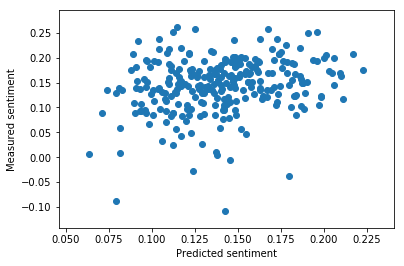

In [308]:
plt.scatter(predicted_senti, fit_df['compound_mean_mean'])
plt.xlabel('Predicted sentiment')
plt.ylabel('Measured sentiment');

### Simple models for abstract
First, a regression model with team wins, age, oldness, PER, and ethnicity

In [180]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.ols( formula = 'compound_mean_mean ~ youth + oldness + Wins + PER + C(Race)',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [181]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.353
Date:                Fri, 28 Sep 2018   Prob (F-statistic):            0.00349
Time:                        15:02:03   Log-Likelihood:                 376.11
No. Observations:                 232   AIC:                            -738.2
Df Residuals:                     225   BIC:                            -714.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1006      0.016      6.208      0.000       0.069       0.133
C(Race)[T.M]     0.0169      0.015      1.112      0.267      -0.013       0.047
C(Race)[T.W]     0.0153      0.008      1.968      0.050   -2.16e-05       0.031
youth            0.0073      0.002      3.962      0.000       0.004       0.011
oldness          0.0028      0.001      2.371      0.019       0.000       0.005
Wins             0.0003      0.000      0.955      0.340      -0.000       0.001
PER              0.0005      0.001      0.889      0.375      -0.001       0.002
==============================================================================
Omnibus:                       74.225   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.726
Skew:                          -1.310   Prob(JB):                     8.02e-56
Kurtosis:                       7.403   Cond. No.                         242.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### With interaction

In [176]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + PER + C(Race) * white_black_diff',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [126]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.070
Model:                            WLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.363
Date:                Fri, 28 Sep 2018   Prob (F-statistic):            0.00179
Time:                        14:38:20   Log-Likelihood:                 492.99
No. Observations:                 323   AIC:                            -970.0
Df Residuals:                     315   BIC:                            -939.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1118      0.017      6.412      0.000       0.077       0.146
C(Race)[T.W]                     -0.0266      0.023     -1.133      0.258      -0.073       0.020
youth                             0.0073      0.002      4.129      0.000       0.004       0.011
oldness                           0.0020      0.001      1.765      0.079      -0.000       0.004
Wins                              0.0001      0.000      0.537      0.592      -0.000       0.001
PER                               0.0010      0.001      1.841      0.067   -6.95e-05       0.002
white_black_diff                 -0.0001      0.000     -0.645      0.519      -0.001       0.000
C(Race)[T.W]:white_black_diff     0.0007      0.000      1.593      0.112      -0.000       0.001
==============================================================================
Omnibus:                       58.807   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.801
Skew:                          -0.907   Prob(JB):                     1.45e-29
Kurtosis:                       5.565   Cond. No.                         607.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + PER + C(Race) * clinton_vote_lead',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [128]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.077
Model:                            WLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.769
Date:                Fri, 28 Sep 2018   Prob (F-statistic):           0.000610
Time:                        14:38:50   Log-Likelihood:                 494.34
No. Observations:                 323   AIC:                            -972.7
Df Residuals:                     315   BIC:                            -942.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0904      0.015      5.852      0.000       0.060       0.121
C(Race)[T.W]                       0.0329      0.016      2.115      0.035       0.002       0.063
youth                              0.0074      0.002      4.234      0.000       0.004       0.011
oldness                            0.0020      0.001      1.768      0.078      -0.000       0.004
Wins                               0.0001      0.000      0.573      0.567      -0.000       0.001
PER                                0.0010      0.001      1.745      0.082      -0.000       0.002
clinton_vote_lead                  0.0381      0.018      2.150      0.032       0.003       0.073
C(Race)[T.W]:clinton_vote_lead    -0.0622      0.036     -1.739      0.083      -0.133       0.008
==============================================================================
Omnibus:                       57.177   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.306
Skew:                          -0.894   Prob(JB):                     6.17e-28
Kurtosis:                       5.473   Cond. No.                         617.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""